# Project title: Diabet Prediction [notebook 'Diabet_Prediction_Models']

## Authors: Denys Herasymuk & Yaroslav Morozevych

## Contents of This Notebook

Click on the section and go to this cell immediately. (works only with Jupyter in browser)

* [Section 1. Explore Data](#section_1)
* [Section 2. Dataframe Balancing & Split Dataframe on Features and Target](#section_2)
* [Section 3. Train, Validate and Test Models](#section_3)
* [Section 4. Compare Results for Different Datasets](#section_4)
* [Conclusion](#conclusion)

When you use `Run All` button with this notebook, you should wait approx. 10-15 mins to get output of all cells.

**How to run notebooks**

* Create a new virtual env with python 3.8
* In terminal run  -- `pip install -r requirements.txt`
* Make notebook trusted, put a tick in the upper right corner

## General Configuration

In [1]:
import os
# to avoid some tensorflow CUDA warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from utils import scale_normalize

import sys
import math
import pickle
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from pprint import pprint
from copy import deepcopy

from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2022-01-16 21:22:17.727389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 21:22:17.727408: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


In [2]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

os.environ["PYTHONWARNINGS"] = "ignore"

## Python & Library Versions

In [3]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__),
             ("tensorflow", tf.__version__),
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.5.1
numpy       1.19.2
pandas      1.3.5
seaborn     0.11.2
sklearn     1.0.1
tensorflow  2.7.0


<a id='section_1'></a>

## Section 1. Explore Data

In our project we are going to use two datasets: Pima Indians and Ranchi-835215. Such we can play with different features and understand really important features, also it helps us to validate better our approach to creating models for diabetes prediction.

In this section we load datasets and make initial description as we have already done it in EDA notebook.

### Pima Indians dataset

In [4]:
# laod dataset with removed record with incorrect values in "BMI", "SkinThickness" & "BloodPressure" columns
diabetes_df = pd.read_csv(os.path.join(".", "data", "diabetes_cleaned.csv"))
diabetes_df = diabetes_df.iloc[: , 1:] # Drop first column of dataframe

In [5]:
diabetes_df.head()

,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
0,6,148,35,0,33.6,0.627,50,1.880,1
1,1,85,29,0,26.6,0.351,31,0.882,0
2,1,89,23,94,28.1,0.167,21,0.240,0
3,0,137,35,168,43.1,2.288,33,1.870,1
4,3,78,32,88,31.0,0.248,26,0.240,1


### Validate Data

In [6]:
diabetes_df.describe()

,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.510242,119.903166,29.186220,113.960894,32.890130,0.501823,31.586592,0.957773,0.333333
std,3.304281,32.975142,10.505807,122.894735,6.875842,0.343643,10.747286,0.528672,0.471844
min,0.000000,0.000000,7.000000,0.000000,18.200000,0.085000,21.000000,0.000000,0.000000
25%,1.000000,97.000000,22.000000,0.000000,27.800000,0.259000,23.000000,0.552000,0.000000
50%,2.000000,115.000000,29.000000,90.000000,32.800000,0.415000,28.000000,0.878000,0.000000
75%,5.000000,141.000000,36.000000,165.000000,36.900000,0.658000,38.000000,1.328000,1.000000
max,17.000000,199.000000,99.000000,846.000000,67.100000,2.420000,81.000000,2.110000,1.000000


In [7]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
DiabetesRisk                0
Outcome                     0
dtype: int64

In [8]:
# Selecting duplicate rows except first.
# Occurrence based on all columns
duplicates = diabetes_df[diabetes_df.duplicated()]

print("Duplicate rows :")
duplicates

Duplicate rows :


,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome


### Ranchi-835215 dataset

In [9]:
ranchi_diabetes_df = pd.read_csv(os.path.join(".", "data", "diabetes_2019_processed.csv"))
ranchi_diabetes_df = ranchi_diabetes_df.iloc[: , 1:] # Drop first column of dataframe

In [10]:
ranchi_diabetes_df.head()

,Age,Family_Diabetes,highBP,BMI,RegularMedicine,Stress,BPLevel,Pregancies,Diabetic
0,2,0,1,39.0,0.0,1,1.0,0.0,0.0
1,2,0,1,28.0,1.0,1,0.0,0.0,0.0
2,1,0,0,24.0,0.0,1,0.0,0.0,0.0
3,2,0,0,23.0,0.0,1,0.0,0.0,0.0
4,1,0,0,27.0,0.0,1,0.0,0.0,0.0


### Validate Data

In [11]:
ranchi_diabetes_df.describe()

,Age,Family_Diabetes,highBP,BMI,RegularMedicine,Stress,BPLevel,Pregancies,Diabetic
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000
mean,0.970067,0.480044,0.242794,25.537694,0.358093,1.221729,0.292683,0.385809,0.291574
std,1.141582,0.499879,0.429009,5.274509,0.479706,0.807604,0.516897,0.909768,0.454739
min,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,22.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,24.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,0.000000,28.000000,1.000000,2.000000,1.000000,0.000000,1.000000
max,3.000000,1.000000,1.000000,45.000000,1.000000,3.000000,2.000000,4.000000,1.000000


In [12]:
ranchi_diabetes_df.isnull().sum()

Age                0
Family_Diabetes    0
highBP             0
BMI                0
RegularMedicine    0
Stress             0
BPLevel            0
Pregancies         0
Diabetic           0
dtype: int64

<a id='section_2'></a>

## Section 2. Dataframe Balancing & Split Dataframe on Features and Target

### Pima Indians dataset

In [13]:
# choose the most relevant features based on data analysis in 01_Process_Data_and_EDA.ipynb
features = ["Pregnancies", "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "DiabetesRisk", "Outcome"]
scaled_df = scale_normalize(df=diabetes_df, features=features)

In [14]:
# separate the dataframe onto features and target
features_df = scaled_df.drop("Outcome", axis="columns")
target_df = diabetes_df[['Outcome']]

In [15]:
SEED = 25
n_folds = 3

# split the data on test and train
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
samples_per_fold = len(y_test)
X_train.describe()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.026907,-0.015174,-0.000175,-0.023233,0.003571,0.010063,0.005302
std,1.018347,0.969375,0.982606,0.981235,0.990420,1.000519,1.002535
min,-1.063322,-3.639559,-0.928170,-2.138477,-1.214084,-0.985966,-1.813348
25%,-0.760402,-0.664852,-0.928170,-0.740982,-0.716011,-0.706566,-0.768248
50%,-0.457482,-0.179186,-0.178863,-0.013120,-0.247065,-0.334032,-0.151034
75%,0.754197,0.610022,0.431984,0.569169,0.498588,0.597303,0.700950
max,4.086316,2.400917,5.131437,3.553402,5.322033,4.602044,2.181508


#### Dataset balancing. Random over-sampling with imblearn

We can notice that our datasets are imbalanced, so logically to increase performance we need to balance train set.
Note that we balance only train set, since we want to stay test set the same to make fair comparison of the model results on test set.

In [16]:
# analyse value proportions
target_df.value_counts()

Outcome
0          358
1          179
dtype: int64

In [17]:
y_train.value_counts()

Outcome
0          291
1          138
dtype: int64

In [18]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=SEED)

# fit predictor and target variable
ros_X_train, ros_y_train = ros.fit_resample(X_train, y_train)

print('Original dataset shape', len(y_train))
print('Resample dataset shape', len(ros_y_train))
print('\nResults after balancing')
ros_y_train.value_counts()

Original dataset shape 429
Resample dataset shape 582


Outcome
0          291
1          291
dtype: int64

#### Dataset balancing. Synthetic Minority Oversampling Technique (SMOTE)

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)

# fit predictor and target variable
smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)

print('Original dataset shape', len(y_train))
print('Resample dataset shape', len(smote_y_train))
print('\nResults after balancing')
smote_y_train.value_counts()

Original dataset shape 429
Resample dataset shape 582


Outcome
0          291
1          291
dtype: int64

### Ranchi-835215 dataset

In [20]:
# choose the most relevant features
features = ["Age", "Family_Diabetes", "highBP", "BMI", "RegularMedicine", "Stress", "BPLevel", "Pregancies", "Diabetic"]
scaled_df = scale_normalize(df=ranchi_diabetes_df, features=features)

# separate the dataframe onto features and target
ranchi_features_df = scaled_df.drop("Diabetic", axis="columns")
ranchi_target_df = ranchi_diabetes_df[['Diabetic']]

# split the data on test and train
ranchi_X_train, ranchi_X_test, ranchi_y_train, ranchi_y_test = train_test_split(ranchi_features_df, ranchi_target_df, test_size=0.2, random_state=SEED)
ranchi__samples_per_fold = len(ranchi_y_test)
ranchi_X_train.describe()

,Age,Family_Diabetes,highBP,BMI,RegularMedicine,Stress,BPLevel,Pregancies
count,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000
mean,-0.017527,0.008018,-0.013115,-0.007282,-0.012107,-0.016955,-0.010804,-0.035341
std,0.990853,1.000982,0.992704,1.003187,0.997028,1.008187,0.998468,0.972357
min,-0.850228,-0.960854,-0.566255,-1.998962,-0.746899,-1.513622,-0.566544,-0.424309
25%,-0.850228,-0.960854,-0.566255,-0.671087,-0.746899,-0.274705,-0.566544,-0.424309
50%,-0.850228,-0.960854,-0.566255,-0.291695,-0.746899,-0.274705,-0.566544,-0.424309
75%,0.902699,1.040741,-0.566255,0.467090,1.338869,0.964213,1.369149,-0.424309
max,1.779162,1.040741,1.765990,3.691927,1.338869,2.203130,3.304843,3.974853


#### Random over-sampling with imblearn

In [21]:
# analyse value proportions
ranchi_target_df.value_counts()

Diabetic
0.0         639
1.0         263
dtype: int64

In [22]:
ranchi_y_train.value_counts()

Diabetic
0.0         513
1.0         208
dtype: int64

In [23]:
# fit predictor and target variable
ros_ranchi_X_train, ros_ranchi_y_train = ros.fit_resample(ranchi_X_train, ranchi_y_train)

print('Original dataset shape', len(ranchi_y_train))
print('Resample dataset shape', len(ros_ranchi_y_train))
print('\nResults after balancing')
ros_ranchi_y_train.value_counts()

Original dataset shape 721
Resample dataset shape 1026


Diabetic
0.0         513
1.0         513
dtype: int64

#### Synthetic Minority Oversampling Technique (SMOTE)

In [24]:
# fit predictor and target variable
smote_ranchi_X_train, smote_ranchi_y_train = smote.fit_resample(ranchi_X_train, ranchi_y_train)

print('Original dataset shape', len(ranchi_y_train))
print('Resample dataset shape', len(smote_ranchi_y_train))
print('\nResults after balancing')
smote_ranchi_y_train.value_counts()

Original dataset shape 721
Resample dataset shape 1026


Diabetic
0.0         513
1.0         513
dtype: int64

<a id='section_3'></a>

## Section 3. Train, Validate and Test Models

Now when the train set is balanced, we can start model development. In this section we are going to train, validate and test models, for each of the best ML and DL model for different datasets we save results in best_results_df to compare them later.

Here the main approach is: fit on train set, tune hyper-parameters on validate set and evaluate on test set. We use the same test set for fair comparison.

In [25]:
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [26]:
def folds_iterator(n_folds, samples_per_fold, size):
    """
    Iterator for GridSearch based on Cross-Validation

    :param n_folds: number of folds for Cross-Validation
    :param samples_per_fold: number of samples per fold
    """
    for i in range(n_folds):
        yield np.arange(0, size - samples_per_fold * (i + 1)), \
              np.arange(size - samples_per_fold * (i + 1), size - samples_per_fold * i)


In [27]:
def validate_model(model, x, y, params, n_folds, samples_per_fold):
    """
    Use GridSearchCV for a special model to find the best hyperparameters based on validation set
    """
    grid_search = GridSearchCV(estimator=model,
                               param_grid=params,
                               scoring={
                                   "F1_Score": make_scorer(f1_score, average='macro'),
                                   "Accuracy_Score": make_scorer(accuracy_score),
                               },
                               refit="F1_Score",
                               n_jobs=-1,
                               cv=folds_iterator(n_folds, samples_per_fold, x.shape[0]))
    grid_search.fit(x, y.values.ravel())
    best_index = grid_search.best_index_

    return grid_search.best_estimator_,\
           grid_search.cv_results_["mean_test_F1_Score"][best_index],\
           grid_search.cv_results_["mean_test_Accuracy_Score"][best_index],\
           grid_search.best_params_


def test_evaluation(cur_best_model, model_name, cur_best_params,
                    cur_x_train, cur_y_train, cur_x_test, cur_y_test,
                    dataset_title, show_plots, debug_mode):
    """
    Evaluate model on test set.

    :return: F1 score, accuracy and predicted values, which we use to visualisations for model comparison later.
    """
    cur_best_model.fit(cur_x_train, cur_y_train.values.ravel()) # refit model on the whole train set
    cur_model_pred = cur_best_model.predict(cur_x_test)
    test_f1_score = f1_score(cur_y_test, cur_model_pred, average='macro')
    test_accuracy = accuracy_score(cur_y_test, cur_model_pred)

    if debug_mode:
        print("#" * 20, f' {dataset_title} ', "#" * 20)
        print('Test model: ', model_name)
        print('Test model parameters:')
        pprint(cur_best_params)

        # print the scores
        print()
        print(classification_report(cur_y_test, cur_model_pred, digits=3))

        if show_plots:
            # plot the confusion matrix
            cm = confusion_matrix(cur_y_test, cur_model_pred, labels=cur_best_model.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
            disp.plot()
            plt.show()
    return test_f1_score, test_accuracy, cur_model_pred


#### Test ML models

In this part we find the best ML model among RandomForestClassifier, DecisionTreeClassifier, SVM and XGBoost.

In [28]:
def test_ML_models(best_results_df, X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode):
    """
    Find the best model from defined list.
    Tune each model on a validation set with GridSearchCV and
    return best_model with its hyper-parameters, which has the highest F1 score
    """
    results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                       'Accuracy_Score',
                                       'Model_Best_Params'))

    config_models = [
        {
            'model_name': 'RandomForestClassifier',
            'model': RandomForestClassifier(random_state=SEED),
            'params': {
                "bootstrap": [True, False],
                "max_depth": [3, 4, 6, 10],
                "min_samples_split": [2, 6],
                "min_samples_leaf": [1, 2, 4],
                "n_estimators": [5 * i for i in range(1, 7)],
                "max_features": [0.6, 'auto', 'sqrt']
            }
        },
        {
            'model_name': 'DecisionTreeClassifier',
            'model': DecisionTreeClassifier(random_state=SEED),
            'params': {
                "max_depth": [2, 3, 4, 6, 10],
                "min_samples_split": [2, 6],
                "min_samples_leaf": [1, 2, 4],
                "max_features": [0.6, 'auto', 'sqrt'],
                "criterion": ["gini", "entropy"]
            }
        },
        {
            'model_name': 'SVC',
            'model': SVC(random_state=SEED),
            'params': {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf'],
            }
        },

        # For XGBoost parameters tuning we used this article --
        # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
        #
        # For faster running this notebook we left only the best combination of parameters,
        # but for experiments e used next ones:
        # 'params': {
        #     'learning_rate': [0.1],
        #     'n_estimators': [100],
        #     'max_depth': range(3,10,2),
        #     'min_child_weight': range(1,6,2),
        #     'gamma': [i/10.0 for i in range(0,5)],
        #     'objective':  ['binary:logistic'],
        #     'nthread': [8]
        # }
        #
        {
            'model_name': 'XGBClassifier',
            'model': XGBClassifier(random_state=SEED),
            'params': {
                'learning_rate': [0.1],
                'n_estimators': [100],
                'max_depth': [4],
                'min_child_weight': [1],
                'gamma': [0.3],
                'objective':  ['binary:logistic'],
                'nthread': [8]
            }
        },
    ]

    best_f1_score = -np.Inf
    best_accuracy = -np.Inf
    best_model_pred = []
    best_model_name = 'No model'
    best_params = None
    idx = 0
    # find the best model among defined in config_models
    for model_config in config_models:
        cur_model, cur_f1_score, cur_accuracy, cur_params = validate_model(deepcopy(model_config['model']),
                                                                    X_train, y_train, model_config['params'],
                                                                    n_folds, samples_per_fold)

        test_f1_score, test_accuracy, cur_model_pred = test_evaluation(cur_model, model_config['model_name'], cur_params,
                                                       X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode)
        # save test results of each model in dataframe
        results_df.loc[idx] = [dataset_title,
                               model_config['model_name'],
                               test_f1_score,
                               test_accuracy,
                               cur_params]
        idx += 1

        if test_f1_score > best_f1_score:
            best_f1_score = test_f1_score
            best_accuracy = test_accuracy
            best_model_name = model_config['model_name']
            best_params = cur_params
            best_model_pred = cur_model_pred

    # append results of best model in best_results_df
    best_results_df.loc[best_results_df.shape[0]] = [dataset_title,
                                                     best_model_name,
                                                     best_f1_score,
                                                     best_accuracy,
                                                     best_params,
                                                     best_model_pred]

    return results_df

#### Results for Pima Indians dataset

If you want, you can set show_plots to True and debug_mode to True to make deeper analysis of each tuned model results on the dataset.

In [29]:
ML_results_df = test_ML_models(best_results_df, X_train, y_train, X_test, y_test, "Pima Indians, Original", show_plots=False, debug_mode=False)
ML_results_df

[21:23:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Pima Indians, Original",RandomForestClassifier,0.788650,0.814815,"{'bootstrap': False, 'max_depth': 3, 'max_feat..."
1,"Pima Indians, Original",DecisionTreeClassifier,0.783764,0.796296,"{'criterion': 'entropy', 'max_depth': 3, 'max_..."
2,"Pima Indians, Original",SVC,0.824121,0.842593,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}"
3,"Pima Indians, Original",XGBClassifier,0.814998,0.833333,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [30]:
ros_ML_results_df = test_ML_models(best_results_df, ros_X_train, ros_y_train, X_test, y_test, "Pima Indians, ROS", show_plots=False, debug_mode=False)
ros_ML_results_df

[21:23:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Pima Indians, ROS",RandomForestClassifier,0.817293,0.833333,"{'bootstrap': False, 'max_depth': 10, 'max_fea..."
1,"Pima Indians, ROS",DecisionTreeClassifier,0.708333,0.740741,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,"Pima Indians, ROS",SVC,0.704110,0.740741,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}"
3,"Pima Indians, ROS",XGBClassifier,0.851852,0.861111,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [31]:
smote_ML_results_df = test_ML_models(best_results_df, smote_X_train, smote_y_train, X_test, y_test, "Pima Indians, SMOTE",
                                         show_plots=False, debug_mode=False)
smote_ML_results_df

[21:24:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:24:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Pima Indians, SMOTE",RandomForestClassifier,0.821324,0.833333,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,"Pima Indians, SMOTE",DecisionTreeClassifier,0.772840,0.787037,"{'criterion': 'entropy', 'max_depth': 6, 'max_..."
2,"Pima Indians, SMOTE",SVC,0.781618,0.796296,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"
3,"Pima Indians, SMOTE",XGBClassifier,0.839465,0.851852,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


#### Results for Ranchi dataset

If you want, you can set show_plots to True and debug_mode to True to make deeper analysis of each tuned model results on the dataset.

In [32]:
ranchi_ML_results_df = test_ML_models(best_results_df, ranchi_X_train, ranchi_y_train,
                                     ranchi_X_test, ranchi_y_test, "Ranchi, Original",
                                     show_plots=False, debug_mode=False)
ranchi_ML_results_df

[21:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:24:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, Original",RandomForestClassifier,0.927030,0.939227,"{'bootstrap': False, 'max_depth': 10, 'max_fea..."
1,"Ranchi, Original",DecisionTreeClassifier,0.933299,0.944751,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,"Ranchi, Original",SVC,0.926218,0.939227,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}"
3,"Ranchi, Original",XGBClassifier,0.929239,0.939227,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [33]:
ranchi_ros_ML_results_df = test_ML_models(best_results_df, ros_ranchi_X_train, ros_ranchi_y_train,
                                      ranchi_X_test, ranchi_y_test, "Ranchi, ROS",
                                      show_plots=False, debug_mode=False)
ranchi_ros_ML_results_df

[21:24:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:24:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, ROS",RandomForestClassifier,0.948286,0.955801,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,"Ranchi, ROS",DecisionTreeClassifier,0.911989,0.922652,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,"Ranchi, ROS",SVC,0.922429,0.933702,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}"
3,"Ranchi, ROS",XGBClassifier,0.917914,0.928177,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [34]:
ranchi_smote_ML_results_df = test_ML_models(best_results_df, smote_ranchi_X_train, smote_ranchi_y_train,
                                            ranchi_X_test, ranchi_y_test, "Ranchi, SMOTE",
                                            show_plots=False, debug_mode=False)
ranchi_smote_ML_results_df

[21:25:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:25:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, SMOTE",RandomForestClassifier,0.891674,0.906077,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,"Ranchi, SMOTE",DecisionTreeClassifier,0.899417,0.911602,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,"Ranchi, SMOTE",SVC,0.907626,0.922652,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}"
3,"Ranchi, SMOTE",XGBClassifier,0.923175,0.933702,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


### Test DL models

In [35]:
def validate_MLPClassifier(X_train_scaled, y_train, debug_mode=False):
    """
    Create and tune MLPClassifier with GridSearchCV.

    :return: fitted model object, F1 score, accuracy score and hyperparameters of best model
    """
    vmlp = MLPClassifier(max_iter=100, random_state=SEED)

    parameter_space = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }

    clf = GridSearchCV(vmlp,
                       parameter_space,
                       n_jobs=-1,
                       cv=3,
                       scoring={
                           "F1_Score": make_scorer(f1_score, average='macro'),
                           "Accuracy_Score": make_scorer(accuracy_score),
                       },
                       refit="F1_Score")
    clf.fit(X_train_scaled, y_train)

    # print all results
    if debug_mode:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    best_index = clf.best_index_
    return clf.best_estimator_,\
           clf.cv_results_["mean_test_F1_Score"][best_index],\
           clf.cv_results_["mean_test_Accuracy_Score"][best_index],\
           clf.best_params_


def test_NN_model(cur_X_train, cur_y_train, cur_X_test, cur_y_test, features_dim, show_plots, debug_mode):
    """
    Create and test own developed NN with 2 hidden layers.
    We took this idea from this paper -- https://www.sciencedirect.com/science/article/pii/S2405959521000205
    [Section 3.5. Neural network model implementation]. However, we also transformed it for our needs.

    :param features_dim: 'input_dim' parameter for the first layer
    """
    model = Sequential()

    # create params dict for NN, it is already tuned manually
    model_params = {
        'layers': [
            {'units': 32, 'activation': 'relu'},
            {'units': 16, 'activation': 'relu'},
            {'units': 1, 'activation': 'sigmoid'},
        ],
        'optimizer': 'adam',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy'],
        'epochs': 200
    }

    # Add first hidden layer
    model.add(Dense(model_params['layers'][0]['units'], activation=model_params['layers'][0]['activation'], input_dim=features_dim))
    # Second hidden layer
    model.add(Dense(model_params['layers'][1]['units'], activation=model_params['layers'][1]['activation']))
    # Output layer
    model.add(Dense(model_params['layers'][2]['units'], activation=model_params['layers'][2]['activation']))
    # Compile the model
    model.compile(optimizer=model_params['optimizer'], loss=model_params['loss'], metrics=model_params['metrics'])
    run_hist_2 = model.fit(cur_X_train, cur_y_train, epochs=model_params['epochs'], verbose=0)

    if show_plots:
        fig, ax = plt.subplots()
        ax.plot(run_hist_2.history["loss"], 'r', marker='.', label="Train Loss")
        plt.show()

    # Train and Test accuracy
    train_accuracy = model.evaluate(cur_X_train, cur_y_train, verbose=0)
    test_accuracy = model.evaluate(cur_X_test, cur_y_test, verbose=0)
    if debug_mode:
        print("Training Accuracy: %.2f%%\n" % (train_accuracy[1]*100))
        print("Testing Accuracy: %.2f%%\n" % (test_accuracy[1]*100))

    y_test_pred = model.predict_classes(cur_X_test)
    test_f1_score = f1_score(cur_y_test, y_test_pred, average='macro')
    test_accuracy = accuracy_score(cur_y_test, y_test_pred)

    if show_plots:
        cm = confusion_matrix(cur_y_test, y_test_pred)
        ax = sns.heatmap(cm,
                         annot=True,
                         xticklabels=["Not ill",'ill'],
                         yticklabels=["Not ill",'ill'])
        ax.set_xlabel('Prediction')
        ax.set_ylabel('Actual')
        plt.show()

    return model_params, test_f1_score, test_accuracy, y_test_pred.ravel()


def test_DL_models(X_train, y_train, X_test, y_test, dataset_title, features_dim, show_plots=False, debug_mode=False):
    # note that we have already scaled our data on the beginning of Section 2 of this notebook,
    # so we do not need to use StandardScaler or similar
    cur_model, cur_f1_score, cur_accuracy, cur_params = validate_MLPClassifier(X_train, y_train, debug_mode)
    MLPClassifier_info = {
        'model_name': 'MLPClassifier',
        'model_params': cur_params
    }
    # get test results for MLPClassifier
    MLPClassifier_info['test_f1_score'], MLPClassifier_info['test_accuracy'], MLPClassifier_info['model_pred'] =\
        test_evaluation(cur_model, MLPClassifier_info['model_name'], cur_params,
                        X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode)

    if debug_mode:
        print('\nModel name: ', "MLPClassifier")
        print('Best model validation params: ')
        print('Mean Test F1 Score: ', cur_f1_score)
        print('Mean Test Accuracy Score: ', cur_accuracy)
        pprint(cur_params)

    results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                       'Accuracy_Score',
                                       'Model_Best_Params'))

    best_f1_score = -np.Inf
    best_model_pred = []
    best_accuracy = -np.Inf
    best_model_name = 'No model'
    best_params = None
    idx = 0
    NN_info = {
        'model_name': 'NN with 2 hidden layers',
    }
    # get test results for own NN
    NN_info['model_params'], NN_info['test_f1_score'], NN_info['test_accuracy'], NN_info['model_pred'] =\
        test_NN_model(X_train, y_train, X_test, y_test, features_dim, show_plots, debug_mode)

    # find the best DL model
    for model_config in [MLPClassifier_info, NN_info]:
        results_df.loc[idx] = [dataset_title,
                               model_config['model_name'],
                               model_config['test_f1_score'],
                               model_config['test_accuracy'],
                               model_config['model_params']]
        idx += 1

        if model_config['test_f1_score'] > best_f1_score:
            best_f1_score = model_config['test_f1_score']
            best_accuracy = model_config['test_accuracy']
            best_model_name = model_config['model_name']
            best_params = model_config['model_params']
            best_model_pred = model_config['model_pred']

    best_results_df.loc[best_results_df.shape[0]] = [dataset_title,
                                                     best_model_name,
                                                     best_f1_score,
                                                     best_accuracy,
                                                     best_params,
                                                     best_model_pred]

    return results_df


#### Results for Pima Indians dataset

In [36]:
test_DL_models(X_train, y_train, X_test, y_test, 'Pima Indians, Original', features_dim=7, show_plots=False, debug_mode=False)

2022-01-16 21:25:59.844563: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-16 21:25:59.844619: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Strix-15-GL503GE): /proc/driver/nvidia/version does not exist
2022-01-16 21:25:59.845090: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Pima Indians, Original",MLPClassifier,0.837594,0.851852,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde..."
1,"Pima Indians, Original",NN with 2 hidden layers,0.765106,0.787037,"{'layers': [{'units': 32, 'activation': 'relu'..."


In [37]:
test_DL_models(ros_X_train, ros_y_train, X_test, y_test, 'Pima Indians, ROS', features_dim=7, show_plots=False, debug_mode=False)

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Pima Indians, ROS",MLPClassifier,0.781618,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
1,"Pima Indians, ROS",NN with 2 hidden layers,0.755413,0.768519,"{'layers': [{'units': 32, 'activation': 'relu'..."


In [39]:
test_DL_models(smote_X_train, smote_y_train, X_test, y_test, 'Pima Indians, SMOTE', features_dim=7, show_plots=False, debug_mode=False)

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Pima Indians, SMOTE",MLPClassifier,0.787478,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
1,"Pima Indians, SMOTE",NN with 2 hidden layers,0.814114,0.824074,"{'layers': [{'units': 32, 'activation': 'relu'..."


#### Results for Ranchi dataset

In [40]:
test_DL_models(ranchi_X_train, ranchi_y_train, ranchi_X_test, ranchi_y_test, 'Ranchi, Original', features_dim=8, show_plots=False, debug_mode=False)

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, Original",MLPClassifier,0.926218,0.939227,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
1,"Ranchi, Original",NN with 2 hidden layers,0.934019,0.944751,"{'layers': [{'units': 32, 'activation': 'relu'..."


In [41]:
test_DL_models(ros_ranchi_X_train, ros_ranchi_y_train, ranchi_X_test, ranchi_y_test, 'Ranchi, ROS', features_dim=8, show_plots=False, debug_mode=False)

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, ROS",MLPClassifier,0.909500,0.922652,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
1,"Ranchi, ROS",NN with 2 hidden layers,0.898514,0.911602,"{'layers': [{'units': 32, 'activation': 'relu'..."


In [42]:
test_DL_models(smote_ranchi_X_train, smote_ranchi_y_train, ranchi_X_test, ranchi_y_test, 'Ranchi, SMOTE',
               features_dim=8, show_plots=False, debug_mode=False)

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, SMOTE",MLPClassifier,0.907626,0.922652,"{'activation': 'relu', 'alpha': 0.05, 'hidden_..."
1,"Ranchi, SMOTE",NN with 2 hidden layers,0.908586,0.922652,"{'layers': [{'units': 32, 'activation': 'relu'..."


<a id='section_4'></a>

## Section 4. Compare Results for Different Datasets

In [47]:
def display_models_info(best_results_df):
    title_to_test_df = {
        "Pima Indians": y_test,
        "Ranchi": ranchi_y_test
    }
    for i in range(best_results_df.shape[0]):
        model_name, dataset_title, cur_model_pred = best_results_df.at[i, 'Model_Name'], best_results_df.at[i, 'Dataset_Name'],\
                                                    best_results_df.at[i, 'Model_Pred']
        print('\n', "#" * 20, f' {dataset_title} ', "#" * 20)
        print('Model name: ', model_name)
        cur_y_test = title_to_test_df[dataset_title.split(',')[0]]

        # print the scores
        print()
        print(classification_report(cur_y_test, cur_model_pred, digits=3))

        # plot the confusion matrix
        cm = confusion_matrix(cur_y_test, cur_model_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
        disp.plot()
        plt.show()

### Print the final table of results

Analyse classification report and confusion matrix for each of the best ML and DL models for different datasets.

Note, ROS in Dataset_Name column means RandomOverSampler from balancing library imblearn.over_sampling.

In [48]:
best_results_df.sort_values('Dataset_Name')

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params,Model_Pred
0,"Pima Indians, Original",SVC,0.824121,0.842593,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
6,"Pima Indians, Original",MLPClassifier,0.837594,0.851852,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
1,"Pima Indians, ROS",XGBClassifier,0.851852,0.861111,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."
7,"Pima Indians, ROS",MLPClassifier,0.781618,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
2,"Pima Indians, SMOTE",XGBClassifier,0.839465,0.851852,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
8,"Pima Indians, SMOTE",NN with 2 hidden layers,0.814114,0.824074,"{'layers': [{'units': 32, 'activation': 'relu'...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ..."
3,"Ranchi, Original",DecisionTreeClassifier,0.933299,0.944751,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,"Ranchi, Original",NN with 2 hidden layers,0.934019,0.944751,"{'layers': [{'units': 32, 'activation': 'relu'...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,"Ranchi, ROS",RandomForestClassifier,0.948286,0.955801,"{'bootstrap': True, 'max_depth': 10, 'max_feat...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,"Ranchi, ROS",MLPClassifier,0.909500,0.922652,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



 ####################  Pima Indians, Original  ####################
Model name:  SVC

              precision    recall  f1-score   support

           0      0.829     0.940     0.881        67
           1      0.875     0.683     0.767        41

    accuracy                          0.843       108
   macro avg      0.852     0.812     0.824       108
weighted avg      0.846     0.843     0.838       108



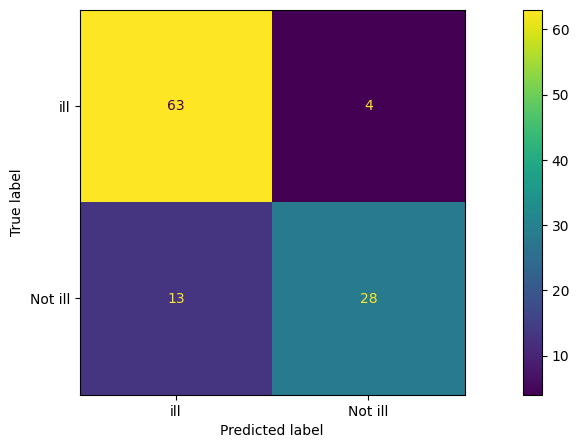


 ####################  Pima Indians, ROS  ####################
Model name:  XGBClassifier

              precision    recall  f1-score   support

           0      0.882     0.896     0.889        67
           1      0.825     0.805     0.815        41

    accuracy                          0.861       108
   macro avg      0.854     0.850     0.852       108
weighted avg      0.861     0.861     0.861       108



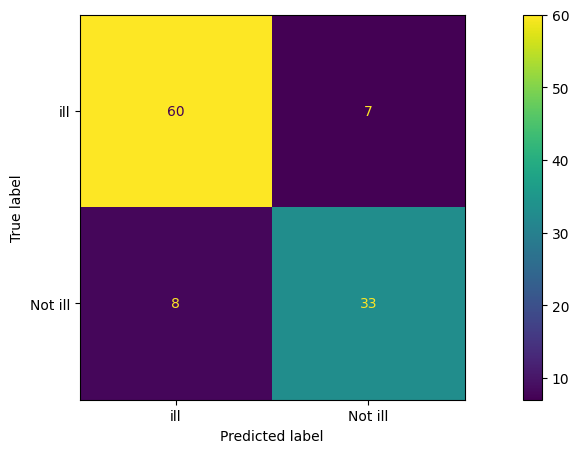


 ####################  Pima Indians, SMOTE  ####################
Model name:  XGBClassifier

              precision    recall  f1-score   support

           0      0.859     0.910     0.884        67
           1      0.838     0.756     0.795        41

    accuracy                          0.852       108
   macro avg      0.848     0.833     0.839       108
weighted avg      0.851     0.852     0.850       108



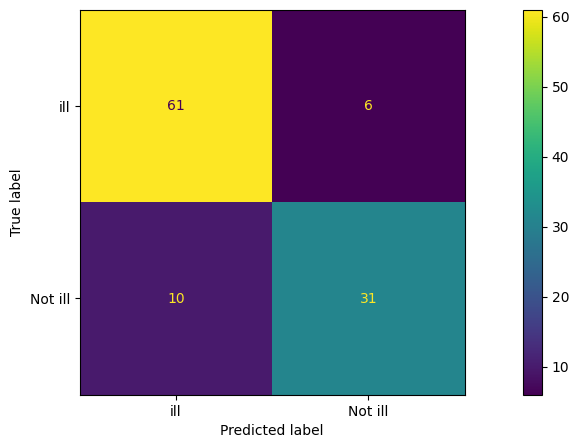


 ####################  Ranchi, Original  ####################
Model name:  DecisionTreeClassifier

              precision    recall  f1-score   support

         0.0      0.946     0.976     0.961       126
         1.0      0.941     0.873     0.906        55

    accuracy                          0.945       181
   macro avg      0.944     0.924     0.933       181
weighted avg      0.945     0.945     0.944       181



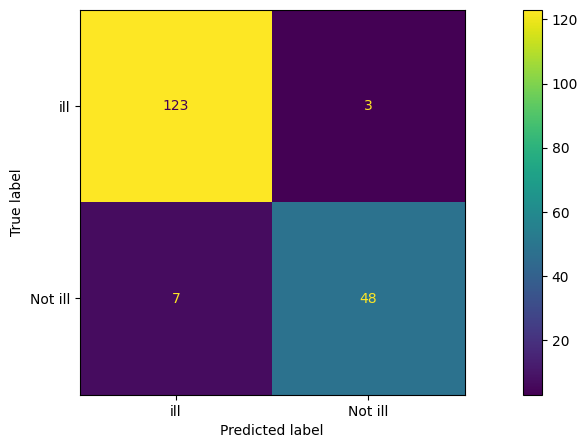


 ####################  Ranchi, ROS  ####################
Model name:  RandomForestClassifier

              precision    recall  f1-score   support

         0.0      0.976     0.960     0.968       126
         1.0      0.912     0.945     0.929        55

    accuracy                          0.956       181
   macro avg      0.944     0.953     0.948       181
weighted avg      0.957     0.956     0.956       181



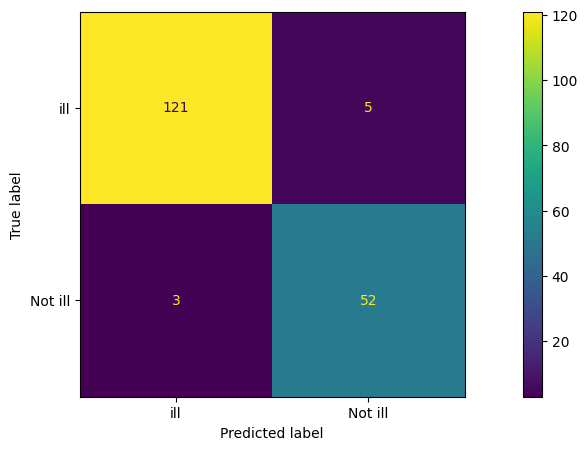


 ####################  Ranchi, SMOTE  ####################
Model name:  XGBClassifier

              precision    recall  f1-score   support

         0.0      0.967     0.937     0.952       126
         1.0      0.864     0.927     0.895        55

    accuracy                          0.934       181
   macro avg      0.916     0.932     0.923       181
weighted avg      0.936     0.934     0.934       181



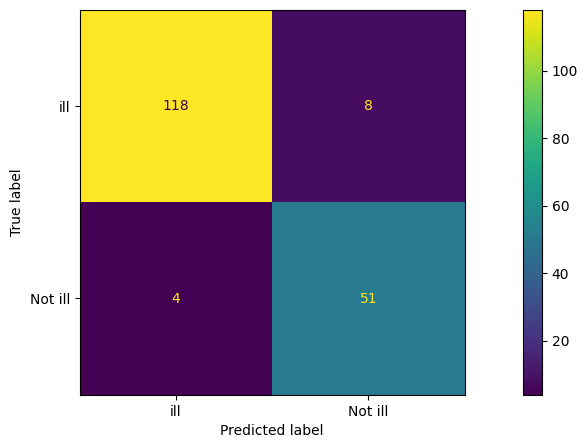


 ####################  Pima Indians, Original  ####################
Model name:  MLPClassifier

              precision    recall  f1-score   support

           0      0.849     0.925     0.886        67
           1      0.857     0.732     0.789        41

    accuracy                          0.852       108
   macro avg      0.853     0.829     0.838       108
weighted avg      0.852     0.852     0.849       108



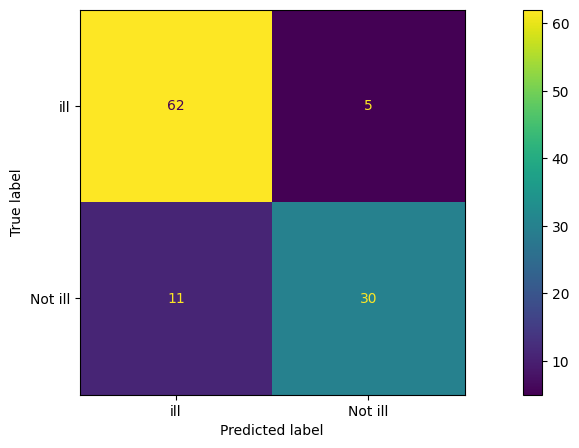


 ####################  Pima Indians, ROS  ####################
Model name:  MLPClassifier

              precision    recall  f1-score   support

           0      0.826     0.851     0.838        67
           1      0.744     0.707     0.725        41

    accuracy                          0.796       108
   macro avg      0.785     0.779     0.782       108
weighted avg      0.795     0.796     0.795       108



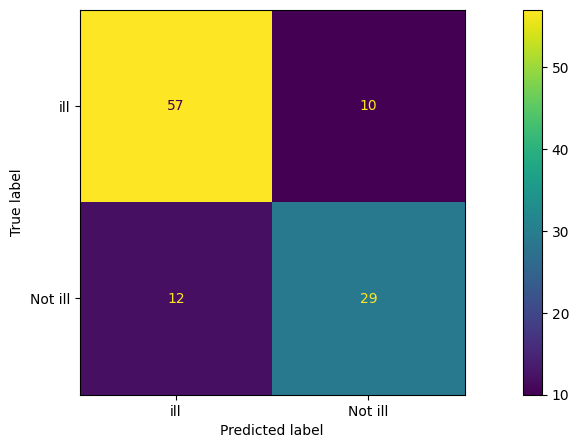


 ####################  Pima Indians, SMOTE  ####################
Model name:  NN with 2 hidden layers

              precision    recall  f1-score   support

           0      0.864     0.851     0.857        67
           1      0.762     0.780     0.771        41

    accuracy                          0.824       108
   macro avg      0.813     0.816     0.814       108
weighted avg      0.825     0.824     0.824       108



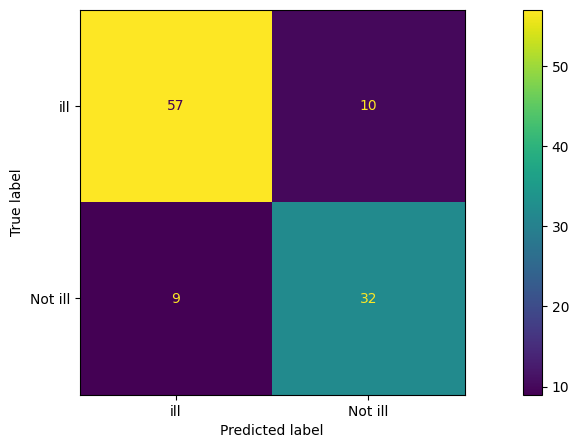


 ####################  Ranchi, Original  ####################
Model name:  NN with 2 hidden layers

              precision    recall  f1-score   support

         0.0      0.953     0.968     0.961       126
         1.0      0.925     0.891     0.907        55

    accuracy                          0.945       181
   macro avg      0.939     0.930     0.934       181
weighted avg      0.944     0.945     0.944       181



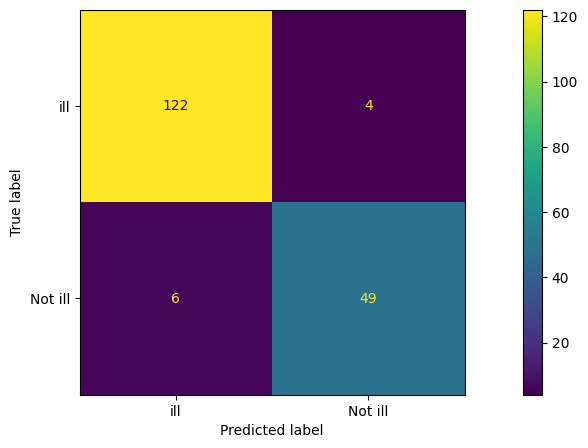


 ####################  Ranchi, ROS  ####################
Model name:  MLPClassifier

              precision    recall  f1-score   support

         0.0      0.952     0.937     0.944       126
         1.0      0.860     0.891     0.875        55

    accuracy                          0.923       181
   macro avg      0.906     0.914     0.909       181
weighted avg      0.924     0.923     0.923       181



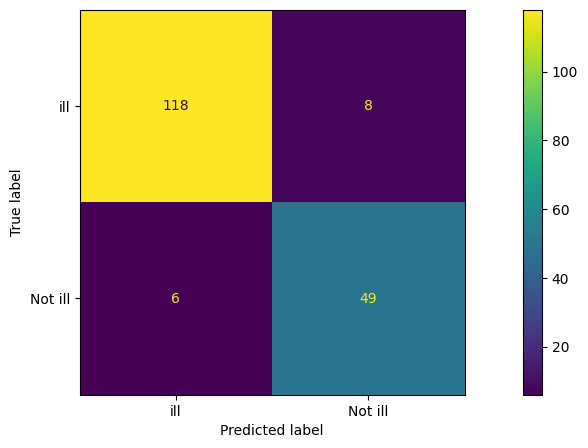


 ####################  Ranchi, SMOTE  ####################
Model name:  NN with 2 hidden layers

              precision    recall  f1-score   support

         0.0      0.944     0.944     0.944       126
         1.0      0.873     0.873     0.873        55

    accuracy                          0.923       181
   macro avg      0.909     0.909     0.909       181
weighted avg      0.923     0.923     0.923       181



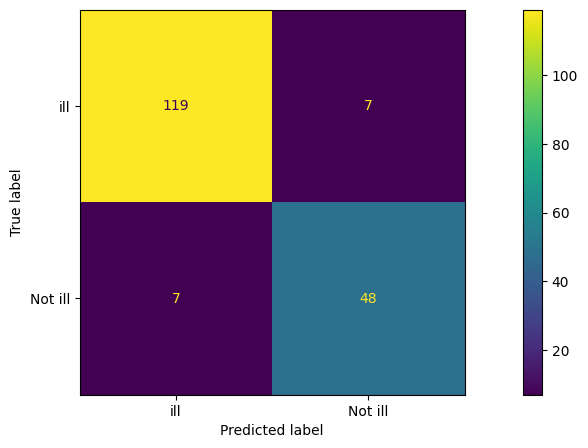

In [49]:
display_models_info(best_results_df)

<a id='conclusion'></a>

## Conclusion

In [50]:
best_results_df.sort_values('Dataset_Name')

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params,Model_Pred
0,"Pima Indians, Original",SVC,0.824121,0.842593,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
6,"Pima Indians, Original",MLPClassifier,0.837594,0.851852,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
1,"Pima Indians, ROS",XGBClassifier,0.851852,0.861111,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."
7,"Pima Indians, ROS",MLPClassifier,0.781618,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
2,"Pima Indians, SMOTE",XGBClassifier,0.839465,0.851852,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
8,"Pima Indians, SMOTE",NN with 2 hidden layers,0.814114,0.824074,"{'layers': [{'units': 32, 'activation': 'relu'...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, ..."
3,"Ranchi, Original",DecisionTreeClassifier,0.933299,0.944751,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,"Ranchi, Original",NN with 2 hidden layers,0.934019,0.944751,"{'layers': [{'units': 32, 'activation': 'relu'...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,"Ranchi, ROS",RandomForestClassifier,0.948286,0.955801,"{'bootstrap': True, 'max_depth': 10, 'max_feat...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,"Ranchi, ROS",MLPClassifier,0.909500,0.922652,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


To summarize all above results, we can highlight the next takeaways:
* Based on F1 score for **Pima Indians dataset with random over-sampling**, **XGBClassifier** shown the best performance -- **0.851852** . It can be explained in facts that dataframe has a small number of features, and idea of gradient boosting very good corresponds to our problem, when we try to understand complicated disease pattern. Also we got good performance pruning after balancing train set.
<br/><br/>
* Based on F1 score for **Ranchi dataset with randon over-sampling**, **RandomForestClassifier** shown the best performance -- **0.948286**. It can be explained in similar manner, but also in this dataset we have in several times higher correlation among features and target, hence, Random Forest could understand this pattern better.
<br/><br/>
* After **testing on different datasets**, we can conclude that our approach shows pretty good results on different datasets. The main point is in feature correlation.In Pima Indians dataset there are a lot of outliers based on their features, so 85% result is a pretty close to maximum result, which we can get from that dataset
<br/><br/>
* **Investigation of the problem area** is pretty useful, especially in medicine problems. After it we came up with several optimization ways like deleting records with incorrect values from medicine point, for example, when blood pressure is 0, so this person is died, so it is mistake in the dataset.
<br/><br/>
* During running experiments, different balancing algorithms shown best results, highlighting **importance of dataset balancing**, even it is synthetic balanced. Nevertheless, we need to be alert with this technique to avoid overfitting anf make good test.
<br/><br/>
* Either we understand that **feature engineering** can increase performance better, even than more deep fin-tuning of hyper-parameters. Due to the EDA process we were able to come up with some thresholds to decide when one has a risk of coming down with diabetes. This, in turn, let us create a unique feature that assigns a certain risk to a person that, eventually, leads to higher model scores as this feature incorporates the information that the other ones convey, slightly enhancing their effect.
<br/><br/>
* Even with GridSearchCV we need to understand at least ranges of main model parameters based on EDA and previous experience.
<br/><br/>
* During paper analysis with the same problem it is good point to be sceptical and except different approaches, also analyse size and parameters of dataset, on which authors conducted experiments. Dataset is the main component in data science.